In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns
from skimage import exposure, io

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import pickle

import warnings
warnings.filterwarnings('ignore')

import tidalUtl.PrpUtl as prp
import tidalUtl.EdaUtl as eda
import tidalUtl.Scheduler as sch

from PIL import Image

from efficientnet_pytorch import EfficientNet 

import albumentations as albu

In [2]:
print(torch.__version__) 

1.7.0+cu110


# Version

__ver1__<br>
baseline：CV cross entropy 0.102：CV accuracy 0.802<br>

# Config

In [3]:
INPUT = "/home/tidal/ML_Data/CIFAR10/cifar-10-python/cifar-10-batches-py"
OUTPUT = "/home/tidal/ML_Data/CIFAR10/output"

SUBMIT = OUTPUT + "/submittion/"
SAVEMODEL = OUTPUT + "/model/Pytorch/"
SAVEOOF = OUTPUT + "/OOF/Pytorch/"
SAVEPLOT = OUTPUT + "/plot_history/"

#ARCH = EfficientNet.from_pretrained('efficientnet-b1') 

# RUN
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 100
BATCH_SIZE = 512
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 5
EARLY_STOPPING_STEPS = 20
EARLY_STOP = True
AUGMENT_PRB = 1
IMG_VSL_FLG_TRAIN = True
IMG_VSL_FLG_VALID = True

In [4]:
#Loading
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metaData = unpickle(INPUT + '/batches.meta')
batch1 = unpickle(INPUT + '/data_batch_1')
batch2 = unpickle(INPUT + '/data_batch_2')
batch3 = unpickle(INPUT + '/data_batch_3')
batch4 = unpickle(INPUT + '/data_batch_4')
batch5 = unpickle(INPUT + '/data_batch_5')
testBatch = unpickle(INPUT + '/test_batch')

#trainは分割されていたのを一つに結合(この時点ではまだseries)
trainFeature = np.concatenate([batch1[b'data'], 
                               batch2[b'data'],
                               batch3[b'data'],
                               batch4[b'data'],
                               batch5[b'data'],])
testFeature = testBatch[b'data']

trainTarget = np.concatenate([batch1[b'labels'], 
                               batch2[b'labels'],
                               batch3[b'labels'],
                               batch4[b'labels'],
                               batch5[b'labels'],])
testTarget = np.array(testBatch[b'labels'])


#pandasとして扱う。
trainFeature = pd.DataFrame(trainFeature)
trainTarget = pd.Series(trainTarget)
testFeature = pd.DataFrame(testFeature)
testTarget = pd.Series(testTarget)

#targetのカラム
tarClmn = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [5]:
#Seed固定
def seed_everything(seed=42):
    #data取得についてのランダム性固定
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #cudnnによる演算の安定化(評価値の安定)
    torch.backends.cudnn.deterministic = True
    
    #os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(seed=42)

In [6]:
#HyperParameter
param_space = {'hidden_size1': 512, 
               'hidden_size2': 512, 
               'dropOutRate1': 0.20393004966355735, 
               'dropOutRate2': 0.39170486751620137,
               'leakyReluSlope': 0.01973893854348531,
              }

# Preprocessing

## Func: In & Out Type is DataFrame

## Collecting

__train,testにターゲット値も連結__

In [7]:
def Collecting(trainFeature, testFeature, trainTarget):
    #targetを結合
    trainFeature = pd.concat([trainFeature, trainTarget], axis=1)
    #test側のtargetは0で初期化しておく
    testTarTmp = pd.DataFrame(np.zeros((testFeature.shape[0],trainTarget.shape[1]),dtype='uint8'), columns=tarClmn)
    testFeature = pd.concat([testFeature, testTarTmp], axis=1)
    
    
    return trainFeature, testFeature

## Preprocessing Summary

In [8]:
def preprocessing(param, trainFeature, testFeature, trainTarget):
    
    #targetのデータフレーム作成（列名も付与）(one-hot化しておく)
    targetOH = pd.get_dummies(trainTarget)
    targetOH.columns = tarClmn
    
    #train,testにターゲット値を連結。
    train, test = Collecting(trainFeature, testFeature, targetOH)
    
    return train, test, targetOH

## Work

## Visualization

In [9]:
%%time
trainVsl, testVsl, targetVsl = preprocessing(param_space, trainFeature, testFeature, trainTarget)

CPU times: user 975 ms, sys: 0 ns, total: 975 ms
Wall time: 974 ms


In [10]:
trainVsl.head(5)

,0,1,2,3,4,5,6,7,8,9,...,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,59,43,50,68,98,119,139,145,149,149,...,0,0,0,0,0,0,1,0,0,0
1,154,126,105,102,125,155,172,180,142,111,...,0,0,0,0,0,0,0,0,0,1
2,255,253,253,253,253,253,253,253,253,253,...,0,0,0,0,0,0,0,0,0,1
3,28,37,38,42,44,40,40,24,32,43,...,0,0,0,0,1,0,0,0,0,0
4,170,168,177,183,181,177,181,184,189,189,...,0,1,0,0,0,0,0,0,0,0


In [11]:
testVsl.head(5)

,0,1,2,3,4,5,6,7,8,9,...,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,158,159,165,166,160,156,162,159,158,159,...,0,0,0,0,0,0,0,0,0,0
1,235,231,232,232,232,232,232,232,232,232,...,0,0,0,0,0,0,0,0,0,0
2,158,158,139,132,166,182,187,193,199,205,...,0,0,0,0,0,0,0,0,0,0
3,155,167,176,190,177,166,168,166,170,179,...,0,0,0,0,0,0,0,0,0,0
4,65,70,48,30,23,40,44,45,45,40,...,0,0,0,0,0,0,0,0,0,0


In [12]:
targetVsl.head(5)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0


In [13]:
print("Train: "+ str(trainVsl.shape))
print("Test: "+ str(testVsl.shape))
print("Target: "+ str(targetVsl.shape))

Train: (50000, 3082)
Test: (10000, 3082)
Target: (50000, 10)


In [14]:
del trainVsl, testVsl, targetVsl 

# Fitting

## Config about Fitting

In [15]:
#configは辞書化しておく。
def Config_about_Fitting(train, test, target, folds):
    confFitting = {}
    
    #Fitするときに"y"として使う列の列名配列
    confFitting["target_cols"] = target.columns.values.tolist()
    #Fitするときに"X"として使う列の列名配列
    #kfold, id等はここで削除。
    feature_cols = [c for c in folds.columns if c not in confFitting["target_cols"]]
    confFitting["feature_cols"] = [c for c in feature_cols if c not in ['kfold','sig_id']]
    #特徴量、ターゲットのサイズ
    confFitting["num_features"]=len(confFitting["feature_cols"])
    confFitting["num_targets"]=len(confFitting["target_cols"])
    
    return confFitting

## CV folds

In [16]:
def CV_folds(train, target):
    folds = train.copy()
    
    skf = StratifiedKFold(n_splits=NFOLDS)
    
    for f, (t_idx, v_idx) in enumerate(skf.split(X=train, y=trainTarget)):
        folds.loc[v_idx, 'kfold'] = int(f)
    
    folds['kfold'] = folds['kfold'].astype(int)
    
    return folds

In [17]:
%%time
#Preprocessing Data
trainVsl, testVsl, targetVsl = preprocessing(param_space, trainFeature, testFeature, trainTarget)
#CV folds
foldsVsl = CV_folds(trainVsl, targetVsl)

foldsVsl.head(5)

CPU times: user 984 ms, sys: 47.9 ms, total: 1.03 s
Wall time: 1.03 s


,0,1,2,3,4,5,6,7,8,9,...,automobile,bird,cat,deer,dog,frog,horse,ship,truck,kfold
0,59,43,50,68,98,119,139,145,149,149,...,0,0,0,0,0,1,0,0,0,0
1,154,126,105,102,125,155,172,180,142,111,...,0,0,0,0,0,0,0,0,1,0
2,255,253,253,253,253,253,253,253,253,253,...,0,0,0,0,0,0,0,0,1,0
3,28,37,38,42,44,40,40,24,32,43,...,0,0,0,1,0,0,0,0,0,0
4,170,168,177,183,181,177,181,184,189,189,...,1,0,0,0,0,0,0,0,0,0


In [18]:
del trainVsl, testVsl, targetVsl, foldsVsl

## Dataset Classes

In [19]:
#Train,Valid用のデータクラス
class TrainDataset:
    def __init__(self, features, targets, p: float = 0.5, transform=None):
        self.features = features
        self.targets = targets
        
        #1列のデータを画像としての形に整形
        self.features = self.features.reshape(self.features.shape[0], 3, 32, 32).astype("uint8")
        #augmentation
        self.transform = transform
        self.p = p #transformの使用有無の判断に使用
        
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        x = self.features[idx, :]
        
        if self.transform:
            if random.random() < self.p: #pの値を大きくするほどtransformの使用率が上がる。
                augmented = self.transform(image=x)
                x = augmented['image']
                del augmented
                        
        #torch.DataLoaderに入れるための形式
        dct = {
            'x' : torch.tensor(x, dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
#Test用のデータクラス
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            #torch.DataLoaderに入れるための形式
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct
    

## Augmentation

In [20]:
def get_augmentation():
    train_transform = [
        #albu.HorizontalFlip(p=1),
        #albu.VerticalFlip(p=1),
        albu.ChannelDropout(channel_drop_range=(1, 1), fill_value=0, p=1),
        #albu.CenterCrop(height=24, width=24, p=1.0),
        #albu.IAASharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1),
        #albu.Normalize(mean=(0,0,0), std=(1,1,1), max_pixel_value = 255.0, p=1.0),
    ]
    return albu.Compose(train_transform)

In [22]:
transformsVsl = get_augmentation()

trainVsl, testVsl, targetVsl = preprocessing(param_space, trainFeature, testFeature, trainTarget)
foldsVsl = CV_folds(trainVsl, targetVsl)
confFitting = Config_about_Fitting(trainVsl, testVsl, targetVsl, foldsVsl)
imgOrg = foldsVsl[confFitting["feature_cols"]].values[0]
imgOrg = imgOrg.reshape(3, 32, 32).transpose(1, 2, 0).astype("uint8")

imgTrs = imgOrg.copy()
augmented = transformsVsl(image=imgTrs)
del transformsVsl

In [23]:
imgTrs.shape

(32, 32, 3)

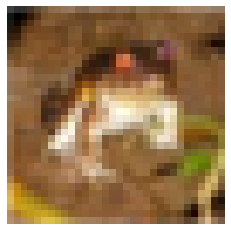

In [24]:
plt.axis('off')
plt.imshow(imgOrg)
plt.show()

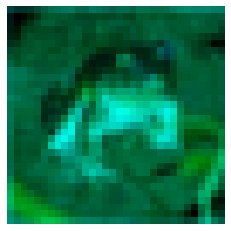

In [25]:
plt.axis('off')
plt.imshow(augmented['image'])
plt.show()

## Loss, Metric

In [26]:
#loss
#nn.BCEWithLogitsLoss()

#class LabelSmoothingCrossEntropy(nn.Module):
#    def __init__(self):
#        super(LabelSmoothingCrossEntropy, self).__init__()
#    def forward(self, x, target, smoothing=0.001):
#        confidence = 1. - smoothing
#        logprobs = F.log_softmax(x, dim=-1)
#        bcs_loss = nn.BCEWithLogitsLoss()(x, target)
#        smooth_loss = -logprobs.mean(dim=-1)
#        loss = confidence * bcs_loss + smoothing * smooth_loss
#        return loss.mean()

In [27]:
#metric
#nn.BCEWithLogitsLoss()

## Func: Fitting, Evaluation, Predict

In [28]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    global IMG_VSL_FLG_TRAIN
    
    for data in dataloader:
        #imageの可視化(最初のデータだけ)
        if IMG_VSL_FLG_TRAIN:
            img = data['x'][0].detach().cpu().numpy().transpose(1, 2, 0).astype("uint8").copy()
            plt.axis('off')
            plt.imshow(img)
            plt.show()
            del img
            IMG_VSL_FLG_TRAIN = False
        
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
#         print(inputs.shape)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    global IMG_VSL_FLG_VALID
    
    for data in dataloader:
        #imageの可視化(最初のデータだけ)
        if IMG_VSL_FLG_VALID:
            img = data['x'][0].detach().cpu().numpy().transpose(1, 2, 0).astype("uint8").copy()
            plt.axis('off')
            plt.imshow(img)
            plt.show()
            del img
            IMG_VSL_FLG_VALID = False
        
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds
   
    

## Model architect

In [29]:
x = torch.randn(4, 3, 1, 1)
x.shape
x.view(-1,3).shape

torch.Size([4, 3])

In [30]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, param):
        super(Model, self).__init__()
        #-------------------前準備---------------------------------------------------------------------
        self.layersCompo = lambda in_ch, out_ch: [torch.nn.Conv2d(in_ch,  # チャネル入力（色の部分）
                                                            out_ch,  # チャンネル出力
                                                            3,       # カーネルサイズ(フィルタサイズ)
                                                            1,       # ストライド (デフォルトは1)
                                                            1,       # パディング (デフォルトは0)
                                                            ), 
                                                  nn.BatchNorm2d(out_ch),
                                                  nn.ReLU(),
                                                  nn.Dropout(p=0.3)]
        
        layersList = []
        
        layersList.extend(self.layersCompo(3, 64))
        layersList.extend(self.layersCompo(64, 64))
        layersList.extend(self.layersCompo(64, 64))
        layersList.append(torch.nn.AvgPool2d(2)) # カーネルサイズ
        
        layersList.extend(self.layersCompo(64, 128))
        layersList.extend(self.layersCompo(128, 128))
        layersList.extend(self.layersCompo(128, 128))
        layersList.append(torch.nn.AvgPool2d(2)) # カーネルサイズ

        layersList.extend(self.layersCompo(128, 256))
        layersList.extend(self.layersCompo(256, 256))
        layersList.extend(self.layersCompo(256, 256))
        
        
        #------------------モデル--------------------------------------------------------------------------
        self.layers = nn.ModuleList(layersList) 
        #F.avg_pool2d(x, kernel_size=x.size()[2:]) #Grobal average pooling　（画像面ごとにまとめる）
        
        self.dense1 = nn.Linear(256, num_targets)
        
    
    def forward(self, x):
        for i in range(len(self.layers)):
            #print(x.shape)
            x = self.layers[i](x)
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        
        x = x.view(-1,256)#[512,256,1,1]->[512,256]
        #print(x.shape)
        x = self.dense1(x)
        
        return x

# Run

## Single Fold Running

In [31]:
def run_training(confFitting, Tester, Plotting, fold, seed, param,
                 folds, train, test, target):
    
    seed_everything(seed)
    
    train = folds
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[confFitting["feature_cols"]].values, train_df[confFitting["target_cols"]].values
    x_valid, y_valid =  valid_df[confFitting["feature_cols"]].values, valid_df[confFitting["target_cols"]].values
    
    #aumentation
    transforms = get_augmentation()
    
    train_dataset = TrainDataset(x_train, y_train, AUGMENT_PRB, transforms)
    valid_dataset = TrainDataset(x_valid, y_valid, AUGMENT_PRB, transforms)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=confFitting["num_features"],
        num_targets=confFitting["num_targets"],
        #arch=ARCH,
        param=param
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    #scheduler = sch.CosineAnnealingWarmupRestarts(optimizer,
    #                                              first_cycle_steps=200,
    #                                              cycle_mult=1.0,
    #                                              max_lr=0.01,
    #                                              min_lr=0.0001,
    #                                              warmup_steps=50,
    #                                              gamma=0.5)
    
    ##### 評価関数 ######
    train_loss_fn = nn.BCEWithLogitsLoss()
    valid_loss_fn = nn.BCEWithLogitsLoss()
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(train), target.shape[1]))
    best_loss = np.inf
    history = {
        'train_loss': [],
        'valid_loss': [],
    }
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, train_loss_fn, trainloader, DEVICE)
        valid_loss, valid_preds = valid_fn(model, valid_loss_fn, validloader, DEVICE)
        if Tester:
            print("EPOCH: {:03}: | train_loss: {:.3f}: | valid_loss: {:.3f}".format(epoch, train_loss, valid_loss))
                
        
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        
        if valid_loss < best_loss:
            best_epoch = epoch
            best_train_loss = train_loss
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"{SAVEMODEL}SEED{seed}_FOLD{fold}.pth")
        
        elif(EARLY_STOP == True):
            early_step += 1
            if (early_step >= early_stopping_steps):
                if Tester:
                    print('Early stopping. Best Val loss: {:.3f}'.format(best_loss))
                break
            
    print("<BEST LOSS> EPOCH: {:03}: | train_loss: {:.3f}: | valid_loss: {:.3f}".format(best_epoch, best_train_loss, best_loss))
    
    #Visuarization
    if Plotting:
        plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label='train_loss')
        plt.plot(range(1, len(history['valid_loss']) + 1), history['valid_loss'], label='valid_loss')
        plt.title(f'Seed{seed} Fold{fold} LOSS VISUARIZATION')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.savefig(f'{SAVEPLOT}Seed{seed}_Fold{fold}_history.png')
        plt.close()
    
    del history
    
    
    #--------------------- PREDICTION---------------------
    #x_test = test[confFitting["feature_cols"]].values
    #testdataset = TestDataset(x_test)
    #testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    #
    #model = Model(
    #    num_features=confFitting["num_features"],
    #    num_targets=confFitting["num_targets"],
    #    arch=ARCH,
    #    param=param
    #)
    #
    #model.load_state_dict(torch.load(f"{SAVEMODEL}SEED{seed}_FOLD{fold}.pth"))
    #model.to(DEVICE)
    #
    predictions = np.zeros((len(test), confFitting["num_targets"]))
    #predictions = inference_fn(model, testloader, DEVICE)
    
    
    return oof, predictions


## K-Fold Running

In [32]:
def run_k_fold(Tester, Plotting, NFOLDS, seed, param,
              folds, train, test, target, confFitting):
    oof = np.zeros((len(train), confFitting["num_targets"]))
    predictions = np.zeros((len(test), confFitting["num_targets"]))
    
    for fold in range(NFOLDS):
        print('=' * 20, 'Fold', fold, '=' * 20)
        oof_, pred_ = run_training(confFitting, Tester, Plotting, fold, seed, param,
                                   folds, train, test, target)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

## CV Evaluation

In [33]:
 def CV_Evaluation(confFitting, oof, target):
    score = []
    
    #cross entropy
    y_true_OH = target[confFitting["target_cols"]].values
    y_pred_proba = oof
    
    score_logloss = 0
    for i in range(confFitting["num_targets"]):
        score_ = log_loss(y_true_OH[:, i], y_pred_proba[:, i]) #問題の評価指標によって変わる。
        score_logloss += score_ / target.shape[1]
        
    print("CV cross entropy: ", score_logloss)
    score.append(score_logloss)
    
    
    #accuracy
    score_accuracy = 0
    y_true = trainTarget.values
    y_pred= np.zeros((trainTarget.shape[0],))
    for i in range(trainTarget.shape[0]):
        #pred_proba->predに変形
        y_pred[i] = np.argmax(oof[i])
    
    score_accuracy = accuracy_score(y_true, y_pred)
    
    print("CV accuracy: ", score_accuracy)
    score.append(score_accuracy)
    
    
    #OOF save
    np.save(SAVEOOF + 'oof', y_pred_proba)
    
    return score

## Postprocessing

In [34]:
# 特になし

## Submit

In [35]:
def Submit(confFitting, predictions, test):
    test[confFitting["target_cols"]] = predictions
    sub = sample_submission.drop(columns=confFitting["target_cols"]).merge(test[['sig_id']+confFitting["target_cols"]], on='sig_id', how='left').fillna(0)
    sub.to_csv(f'{SUBMIT}submission.csv', index=False)

    print("sub.shape" + str(sub.shape))
    
    return

# Execute

In [36]:
def Exec(param):
    
    #Tester(True/False)
    Tester = True
    
    #Plot(True/False)
    Plotting = True
    
    #Preprocessing Data
    train, test, target = preprocessing(param, trainFeature, testFeature, trainTarget)
    
    #CV folds
    folds = CV_folds(train, target)
    
    #Config about Fitting
    confFitting = Config_about_Fitting(train, test, target, folds)
    
    # Averaging on multiple SEEDS
    SEED = [42]
    oof = np.zeros((len(train), confFitting["num_targets"]))
    predictions = np.zeros((len(test), confFitting["num_targets"]))
    
    ### RUN ###
    for seed in SEED:
        print('~' * 20, 'SEED', seed, '~' * 20)
        oof_, predictions_ = run_k_fold(Tester, Plotting, NFOLDS, seed, param,
                                       folds, train, test, target, confFitting)
        oof += oof_ / len(SEED)
        predictions += predictions_ / len(SEED)
    
    #CV 評価
    score = CV_Evaluation(confFitting, oof, target)
    
    # 課題提出
    #Submit(confFitting, predictions, test)
    
    return score, oof, predictions


~~~~~~~~~~~~~~~~~~~~ SEED 42 ~~~~~~~~~~~~~~~~~~~~
==================== Fold 0 ====================


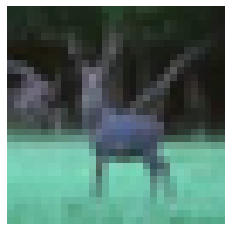

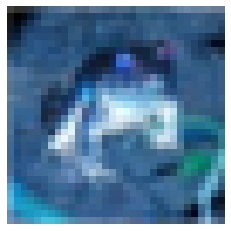

EPOCH: 000: | train_loss: 0.597: | valid_loss: 0.380


KeyboardInterrupt: 

In [37]:
%%time
score, oof, predictions = Exec(param_space)

In [38]:
oof[3]

NameError: name 'oof' is not defined

In [ ]:
oof[3][np.argmax(oof[3])]

In [ ]:
np.argmax(oof[2])

In [ ]:
oof.shape

In [ ]:
_, _, targetVsl = preprocessing(param_space, trainFeature, testFeature, trainTarget)

In [ ]:
trainTarget.values

In [ ]:
y_pred= np.zeros((trainTarget.shape[0],))
for i in range(trainTarget.shape[0]):
    y_pred[i] = np.argmax(oof[i])

In [ ]:
y_pred

# Predict

In [ ]:
def run_predict(confFitting, param, test, target, fold, seed):
    
    seed_everything(seed)
  
    #--------------------- PREDICTION---------------------
    x_test = test[confFitting["feature_cols"]].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=confFitting["num_features"],
        num_targets=confFitting["num_targets"],
        param=param
    )
    
    model.load_state_dict(torch.load(f"{SAVEMODEL}SEED{seed}_FOLD{fold}.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    
    return predictions


In [ ]:
def run_k_fold_predict(confFitting, test, target, param, Tester, NFOLDS, seed):
    predictions = np.zeros((len(test), confFitting["num_targets"]))
    
    for fold in range(NFOLDS):
        if Tester:
            print('=' * 20, 'Fold', fold, '=' * 20)
        pred_ = run_predict(confFitting, param, test, target, fold, seed)
        
        predictions += pred_ / NFOLDS
        
    return predictions

In [ ]:
def SubmitPredict(confFitting, predictions, test, prefix):
    test[confFitting["target_cols"]] = predictions
    sub = sample_submission.drop(columns=confFitting["target_cols"]).merge(test[['sig_id']+confFitting["target_cols"]], on='sig_id', how='left').fillna(0)
    sub.to_csv(f'{SUBMIT}{prefix}submission.csv', index=False)

    print("sub.shape" + str(sub.shape))
    
    return

In [ ]:
def Predict(param):
    #Tester(True/False)
    Tester = False
    
    #Preprocessing Data
    train, test, target = preprocessing(param, trainFeature, testFeature, trainTargetScored)
    
    #CV folds
    folds = CV_folds(train, target)
    
    #Config about Fitting
    confFitting = Config_about_Fitting(train, test, target, folds)
    
    # Averaging on multiple SEEDS
    SEED = [0, 1, 2, 3 ,4, 5]
    predictions = np.zeros((len(test), confFitting["num_targets"]))
    
    ### RUN ###
    for seed in SEED:
        if Tester:
            print('~' * 20, 'SEED', seed, '~' * 20)
        predictions_ = run_k_fold_predict(confFitting, test, target, param, Tester, NFOLDS, seed)
        predictions += predictions_ / len(SEED)
    
    # 課題提出
    prefix = "Pytorch"
    SubmitPredict(confFitting, predictions, test, prefix)
    
    return

In [ ]:
%%time
#Predict(param_space)

# Hyperparameter Tuning

In [ ]:
#hyperopt
from hyperopt import fmin, tpe, hp, rand, Trials

In [ ]:
def HOptExec(param):
    #Tester(True/False)
    Tester = False
    
    #Preprocessing Data
    train, test, target = preprocessing(param, trainFeature, testFeature, trainTargetScored)
    
    #CV folds
    folds = CV_folds(train, target)
    
    #Config about Fitting
    confFitting = Config_about_Fitting(train, test, target, folds)
    
    # Averaging on multiple SEEDS
    SEED = [0, 1, 2, 3 ,4, 5]
    oof = np.zeros((len(train), confFitting["num_targets"]))
    predictions = np.zeros((len(test), confFitting["num_targets"]))
    
    ### RUN ###
    for seed in SEED:
        if Tester:
            print('~' * 20, 'SEED', seed, '~' * 20)
        oof_, predictions_ = run_k_fold(Tester, NFOLDS, seed, param,
                                       folds, train, test, target, confFitting)
        oof += oof_ / len(SEED)
        predictions += predictions_ / len(SEED)
    
    #CV 評価
    score = CV_Evaluation(confFitting, oof, train, target)
    
    # 課題提出
    #Submit(confFitting, predictions, test)
    
    return score

In [ ]:
%%time

#param_space = {'hidden_size1': 512, 
#               'hidden_size2': 512, 
#               'dropOutRate1': 0.20393004966355735, 
#               'dropOutRate2': 0.39170486751620137,
#               'rankGauss_n_quantiles': 488.0393350201078,
#               'leakyReluSlope': hp.uniform('leakyReluSlope', 1e-3, 1e-1),
#              }
#
#trials = Trials()
#
#hopt = fmin(fn = HOptExec, 
#            space = param_space, 
#            algo = tpe.suggest, 
#            max_evals = 15, 
#            #timeout = 8.9 * 60 * 60, 
#            trials = trials, 
#           )
#
#print(hopt)